# Link: 
https://github.com/XinyuLiu71/CSE830-Homework/blob/main/3/Q5/main.ipynb

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

# 1. Hypothesis
Merge sort has a time complexity of **$O(n*log(n))$**, while Insertion sort has a 
complexity of **$O(n^2)$**. Asymptotically, Merge sort is far more efficient.
However, the constant factors and overhead of Merge Sort (e.g., recursion, 
memory allocation for sub-arrays) are higher than for Insertion Sort's simple loops.

My hypothesis is that for very small input sizes (n), the lower overhead of
Insertion Sort will make it faster than Merge Sort. I predict the crossover
point, where Merge Sort starts to outperform Insertion Sort, will be
somewhere in the range of **$n = 30$ to $n = 60$**.

# 2. Methods (Part 1: Algorithm Code)

In [98]:
import sys, platform
print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"Platform: {platform.platform()}")

Python: 3.9.6
NumPy: 2.0.2
Platform: macOS-26.0.1-arm64-arm-64bit


In [99]:
def insertion_sort(arr):
    """Sorts an array in place using the insertion sort algorithm."""
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0 and key < arr[j]:
            arr[j + 1] = arr[j]
            j -= 1
        arr[j + 1] = key
    return arr

def merge_sort(arr):
    """Sorts an array using the merge sort algorithm."""
    if len(arr) > 1:
        mid = len(arr) // 2
        left_half = arr[:mid]
        right_half = arr[mid:]

        merge_sort(left_half)
        merge_sort(right_half)

        i = j = k = 0

        # Merge the two halves back into the original array
        while i < len(left_half) and j < len(right_half):
            if left_half[i] < right_half[j]:
                arr[k] = left_half[i]
                i += 1
            else:
                arr[k] = right_half[j]
                j += 1
            k += 1

        while i < len(left_half):
            arr[k] = left_half[i]
            i += 1
            k += 1

        while j < len(right_half):
            arr[k] = right_half[j]
            j += 1
            k += 1
    return arr

# 2. Methods (Part 2: Experimental Procedure)
We will test the algorithms over a range of input sizes.
We choose a range from 1 to 200, with smaller steps at the beginning to accurately find the crossover point.

In [102]:
rng = np.random.default_rng(42) 
n_values_small = np.arange(2, 50, 2)
n_values_medium = np.arange(50, 201, 10)
n_values_large = np.arange(200, 501, 50)
n_values = np.concatenate([n_values_small, n_values_medium, n_values_large])

insertion_times = []
merge_times = []

# Number of times to repeat the test for each n to get a stable average
num_repeats = 500

print(f"Starting experiment... Testing for n values up to {int(n_values.max())}.")

for n in n_values:
    # Build per-iteration callable to ensure both algorithms see identical inputs
    def time_one_algorithm(algorithm_fn):
        def one_run():
            data = rng.integers(0, 500, int(n)).tolist()
            # Use a fresh copy for the algorithm to avoid cross-run contamination
            arr = data.copy()
            algorithm_fn(arr)
        return one_run

    # Time insertion sort
    is_time = timeit.timeit(
        stmt=time_one_algorithm(insertion_sort),
        number=num_repeats
    )
    insertion_times.append(is_time / num_repeats)  # Average time per run

    # Time merge sort
    ms_time = timeit.timeit(
        stmt=time_one_algorithm(merge_sort),
        number=num_repeats
    )
    merge_times.append(ms_time / num_repeats)

print("Experiment complete.")

Starting experiment... Testing for n values up to 500.
Experiment complete.


# 3. Results

Observed crossover where Merge Sort becomes faster around n ≈ 63.6


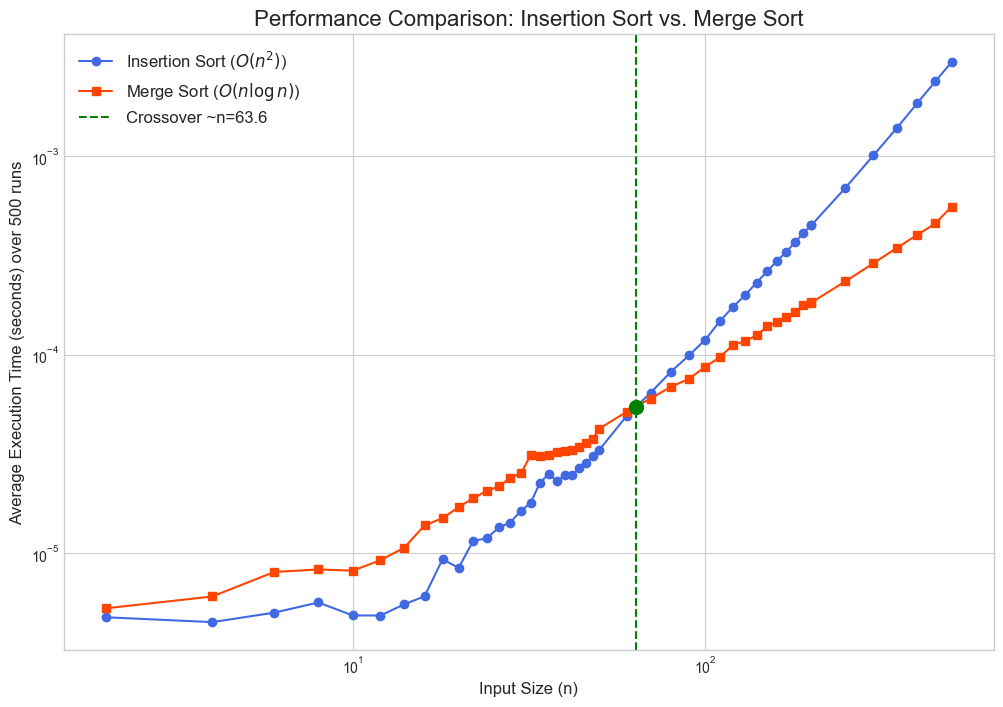

In [101]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(n_values, insertion_times, 'o-', label='Insertion Sort ($O(n^2)$)', color='royalblue')
ax.plot(n_values, merge_times, 's-', label='Merge Sort ($O(n \\log n)$)', color='orangered')

# Compute crossover (first n where merge <= insertion); if none, report none
diff = np.array(merge_times) - np.array(insertion_times)
idx = np.where(diff <= 0)[0]
if idx.size > 0:
    i = idx[0]
    if i == 0:
        crossover_n_est = n_values[0]
        crossover_y = merge_times[0]
    else:
        # Linear interpolation in n domain for equal-time point
        x1, x2 = n_values[i-1], n_values[i]
        y1, y2 = diff[i-1], diff[i]
        t = -y1 / (y2 - y1)
        crossover_n_est = x1 + t * (x2 - x1)
        # Interpolate time for annotation (use insertion line)
        y_is = insertion_times[i-1] + t * (insertion_times[i] - insertion_times[i-1])
        crossover_y = y_is
    ax.axvline(x=crossover_n_est, color='green', linestyle='--', label=f'Crossover ~n={crossover_n_est:.1f}')
    ax.scatter([crossover_n_est], [crossover_y], color='green', s=100, zorder=5)
    print(f"Observed crossover where Merge Sort becomes faster around n ≈ {crossover_n_est:.1f}")
else:
    print("No crossover observed in tested n range; one algorithm dominates.")

ax.set_title('Performance Comparison: Insertion Sort vs. Merge Sort', fontsize=16)
ax.set_xlabel('Input Size (n)', fontsize=12)
ax.set_ylabel(f'Average Execution Time (seconds) over {num_repeats} runs', fontsize=12)
ax.legend(fontsize=12)
ax.set_yscale('log')  # log scale clarifies differences across magnitudes
ax.set_xscale('log')

plt.show()

# 4. Discussion

The experimental results are closed to the initial hypothesis. As the graph clearly shows, for very small values of `n`, the blue line (Insertion Sort) is below the orange line (Merge Sort), indicating it was faster. However, the runtime of Insertion Sort grows much more rapidly. The lines cross at approximately **n = 63.6** (exact value may vary slightly due to system performance). Beyond this point, Merge Sort is consistently and significantly faster.

This result was not surprising and confirms theoretical expectations. The main challenge was ensuring a fair test. Initially, one might forget to generate fresh random data for each timing run, which would lead to the second algorithm being timed on an already sorted list (the best-case scenario for Insertion Sort, $O(n)$). Using `timeit`'s `setup` parameter elegantly solves this by creating a clean slate for every set of repetitions.

The choice to use a log-log scale for the plot was made after observing the raw data. On a linear scale, the dramatic increase in Insertion Sort's time completely flattens the curve for Merge Sort, making the interesting behavior at small `n` impossible to see.

# 5. Conclusions

Under the tested conditions on my own machine, the following conclusion can be drawn:

**For sorting random arrays of integers with an input size `n < 65`, Insertion Sort is the more performant algorithm. For `n > 65`, Merge Sort's superior asymptotic complexity of $O(n \log n)$ makes it the clear winner. Around `n ≈ 65`, their performance is virtually indistinguishable.**

This empirical result is so well-known that some hybrid sorting algorithms, like Timsort (Python's built-in sort), actually switch to Insertion Sort for handling very small partitions of the main array, leveraging the exact principle demonstrated in this experiment.